In [1]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import flopy
import pyemu
import lumpyrem as lr
from lumpyrem import run
from lumpyrem.lr2series import TimeSeries
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries

In [4]:
lr_ws = os.path.join('..', 'temp_lr_prep') # Lumprem model workspace.  Safe to delete.

In [5]:
lumprem_input_pth = os.path.join('..', 'data', 'lumprem_input') # Input data curated in a previous notebook
os.listdir(lumprem_input_pth)

['evapot.dat', 'rainfall.dat']

In [6]:
if os.path.exists(lr_ws):
    shutil.rmtree(lr_ws)
os.mkdir(lr_ws)

In [7]:
for file in os.listdir(lumprem_input_pth):
    shutil.copyfile(lumprem_input_pth+'\\'+file, lr_ws+'\\'+file) #Works for Windows. Does it work for Linux?

In [8]:
os.listdir(lr_ws)

['evapot.dat', 'rainfall.dat']

## Setup recharge model
The recharge model produces TS files for the RCH package, as well as rainfall and evaporation for SFR stream reaches.

In [9]:
# initiate the model and write the in files. What about rbuf & mbuf?
# landuse model for recharge, evap
lr_lu1 = lr.lumprem.Model(
    model_name = 'lu1',
    workspace = lr_ws,
    ### Earth properties row 1
    maxvol = 0.54, # -- PEST adjustable parameter
    irrigvolfrac = 0.0,
    ### Earth properties row 3
    ks = 153.0, # -- PEST adjustable parameter
    M = 0.17, # -- PEST adjustable parameter
    ### Initial conditions
    vol = 0.268,
    ### Data filenames
    vegfile=(2.207, 2.07), #cropfac_all, gamma_all -- PEST adjustable parameter
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [10]:
#lr.lumprem.Model??

In [11]:
lr_lu1.write_model(
    start_date = '01/12/2015',
    end_date = '01/01/2020',
    noutdays = 212,
    nstep = 200,
    mxiter = 10000,
    tol = 1e-7,
)
lr_lu1.run_model(version=2)

LUMPREM model input file written to: 
..\temp_lr_prep\lr_lu1.in
PEST template file written to: 
..\temp_lr_prep\lr_lu1.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_lu1.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_lu1.out written ok.
 - file lr_lu1.csv written ok.



In [12]:
# get model results
results = lr_lu1.get_results()
display(results.head())

days  vol_upper  vol_lower  vol_drain  vol_macro  del_vol_upper  \
0     0   0.268000        0.0   0.000000        0.0       0.000000   
1     7   0.273031        0.0   0.005273        0.0       0.005031   
2    14   0.265638        0.0   0.004407        0.0      -0.007393   
3    21   0.265078        0.0   0.003973        0.0      -0.000560   
4    28   0.266054        0.0   0.003880        0.0       0.000976   

   del_vol_lower  del_vol_drain  del_vol_macro  rainfall  ...  \
0            0.0       0.000000            0.0    0.0000  ...   
1            0.0       0.005273            0.0    0.0162  ...   
2            0.0      -0.000865            0.0    0.0034  ...   
3            0.0      -0.000434            0.0    0.0091  ...   
4            0.0      -0.000093            0.0    0.0107  ...   

         workspace  maxvol_br  extravol_br  gamma_br  ks_br  m_br  l_br  \
0  ..\temp_lr_prep        NaN          NaN       NaN    NaN   NaN   NaN   
1  ..\temp_lr_prep        NaN          NaN       NaN    NaN   NaN   NaN   
2  ..\temp_lr_prep        NaN          NaN       NaN    NaN   NaN   NaN   
3  ..\temp_lr_prep        NaN          NaN       NaN    NaN   NaN   NaN   
4  ..\temp_lr_prep        NaN          NaN       NaN    NaN   NaN   NaN   

   vol_br  epotfile_br  epot_br_all  
0     NaN          NaN          NaN  
1     NaN          NaN          NaN  
2     NaN          NaN          NaN  
3     NaN          NaN          NaN  
4     NaN          NaN          NaN  

[5 rows x 58 columns]

In [13]:
display(results.columns)

Index(['days', 'vol_upper', 'vol_lower', 'vol_drain', 'vol_macro',
       'del_vol_upper', 'del_vol_lower', 'del_vol_drain', 'del_vol_macro',
       'rainfall', 'irrigation', 'drain_upper', 'macro_upper', 'drain_lower',
       'overflow_lower', 'total_rech', 'gw_withdrawal', 'net_recharge',
       'runoff', 'pot_evap_upper', 'evap_upper', 'pot_evap_lower',
       'evap_lower', 'gw_pot_evap', 'balance', 'elevation', 'depth-to-water',
       'lumprem_model_name', 'rainfile', 'epotfile', 'vegfile', 'irrigfile',
       'maxvol', 'irrigvolfrac', 'rdelay', 'mdelay', 'ks', 'M', 'L',
       'mflowmax', 'offset', 'factor1', 'factor2', 'power', 'elevmin',
       'elevmax', 'surface', 'vol', 'workspace', 'maxvol_br', 'extravol_br',
       'gamma_br', 'ks_br', 'm_br', 'l_br', 'vol_br', 'epotfile_br',
       'epot_br_all'],
      dtype='object')

In [14]:
results.net_recharge.sum()

0.7236618574929999

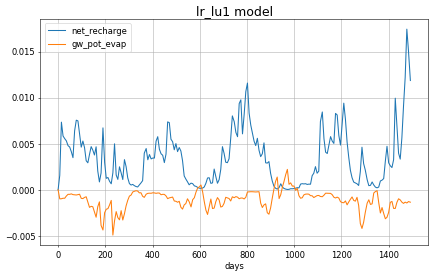

In [15]:
fig = plt.figure(figsize=(10, 6), dpi=50)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('lr_lu1 model', fontsize=18)

results.plot('days','net_recharge', ax=ax)
results.plot('days', 'gw_pot_evap', ax=ax)
plt.grid()
plt.legend()
plt.show()

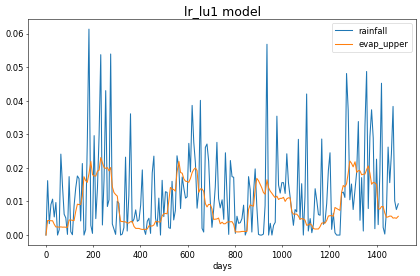

In [16]:
fig = plt.figure(figsize=(10, 6), dpi=50)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('lr_lu1 model', fontsize=18)

results.plot('days','rainfall', ax=ax)
results.plot('days', 'evap_upper', ax=ax)

plt.legend()
plt.show()

## Setup GHB models

GHB Models:

In [17]:
lr_ghb_red = lr.lumprem.Model(
    model_name = 'red',
    workspace = lr_ws,
    ### Earth properties row 1
    maxvol = 0.54, # -- PEST adjustable parameter
    irrigvolfrac = 0.0,
    ### Earth properties row 3
    ks = 153.0, # -- PEST adjustable parameter
    M = 0.17, # -- PEST adjustable parameter
    L = 0.5, # -- PEST adjustable parameter
    ### Volume to elevation
    factor1 = 1.06, # -- PEST adjustable parameter
    factor2 = 0.83, # -- PEST adjustable parameter
    power = 0.72, # -- PEST adjustable parameter
    offset = 140.5, # Measured head in nearby well
    ### Initial conditions
    vol = 0.268, # -- PEST adjustable parameter
    ### Data filenames
    vegfile=(2.207, 2.07), #cropfac_all, gamma_all -- PEST adjustable parameter
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [18]:
lr_ghb_yellow = lr.lumprem.Model(
    model_name = 'yellow',
    workspace = lr_ws,
    ### Earth properties row 1
    maxvol = 0.54, # -- PEST adjustable parameter
    irrigvolfrac = 0.0,
    ### Earth properties row 3
    ks = 153.0, # -- PEST adjustable parameter
    M = 0.17, # -- PEST adjustable parameter
    L = 0.5, # -- PEST adjustable parameter
    ### Volume to elevation
    factor1 = 1.06, # -- PEST adjustable parameter
    factor2 = 0.83, # -- PEST adjustable parameter
    power = 0.72, # -- PEST adjustable parameter
    offset = 139.0, # Measured head in nearby well
    ### Initial conditions
    vol = 0.268, # -- PEST adjustable parameter
    ### Data filenames
    vegfile=(2.207, 2.07), #cropfac_all, gamma_all -- PEST adjustable parameter
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [19]:
lr_ghb_green = lr.lumprem.Model(
    model_name = 'green',
    workspace = lr_ws,
    ### Earth properties row 1
    maxvol = 0.54, # -- PEST adjustable parameter
    irrigvolfrac = 0.0,
    ### Earth properties row 3
    ks = 153.0, # -- PEST adjustable parameter
    M = 0.17, # -- PEST adjustable parameter
    L = 0.5, # -- PEST adjustable parameter
    ### Volume to elevation
    factor1 = 1.06, # -- PEST adjustable parameter
    factor2 = 0.83, # -- PEST adjustable parameter
    power = 0.72, # -- PEST adjustable parameter
    offset = 132.6, # Measured head in nearby well
    ### Initial conditions
    vol = 0.268, # -- PEST adjustable parameter
    ### Data filenames
    vegfile=(2.207, 2.07), #cropfac_all, gamma_all -- PEST adjustable parameter
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [20]:
lr_ghb_blue = lr.lumprem.Model(
    model_name = 'blue',
    workspace = lr_ws,
    ### Earth properties row 1
    maxvol = 0.54, # -- PEST adjustable parameter
    irrigvolfrac = 0.0,
    ### Earth properties row 3
    ks = 153.0, # -- PEST adjustable parameter
    M = 0.17, # -- PEST adjustable parameter
    L = 0.5, # -- PEST adjustable parameter
    ### Volume to elevation
    factor1 = 1.06, # -- PEST adjustable parameter
    factor2 = 0.83, # -- PEST adjustable parameter
    power = 0.72, # -- PEST adjustable parameter
    offset = 136.0, # Measured head in nearby well
    ### Initial conditions
    vol = 0.268, # -- PEST adjustable parameter
    ### Data filenames
    vegfile=(2.207, 2.07), #cropfac_all, gamma_all -- PEST adjustable parameter
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [21]:
ghb_models = [lr_ghb_red, lr_ghb_yellow, lr_ghb_green, lr_ghb_blue]
for model in ghb_models:
    model.write_model(
        start_date = '01/12/2015',
        end_date = '01/01/2020',
        noutdays=212,
        nstep = 200,
        mxiter = 10000,
        tol = 1e-7,
    )
    model.run_model(version=2)

LUMPREM model input file written to: 
..\temp_lr_prep\lr_red.in
PEST template file written to: 
..\temp_lr_prep\lr_red.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_red.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_red.out written ok.
 - file lr_red.csv written ok.

LUMPREM model input file written to: 
..\temp_lr_prep\lr_yellow.in
PEST template file written to: 
..\temp_lr_prep\lr_yellow.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_yellow.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_yellow.out written ok.
 - file lr_yellow.csv written ok.

LUMPREM model input file written to: 
..\temp_lr_prep\lr_green.in
PEST template file writte

In [22]:
lr_ghb_red_df = lr_ghb_red.get_results()

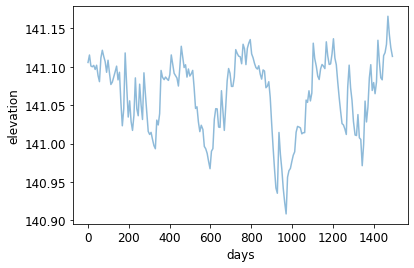

In [23]:
# plot the model results
import seaborn as sb
sb.lineplot(data=lr_ghb_red_df, x='days',y='elevation', alpha=0.5);

# load the simulation

In [24]:
org_model_ws = os.path.join('..', 'base_model_files')
#os.listdir(org_model_ws)

In [25]:
tmp_model_ws = os.path.join('..', 'temp_flopy_lumprem') # Safe to delete
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
#os.listdir(tmp_model_ws)

'..\\temp_flopy_lumprem'

In [26]:
ml_name = 'hagfors_1'

In [27]:
sim = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), tmp_model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package rch...
    loading package ghb...
    loading package sto...
    loading package oc...
    loading package npf...
    loading package ic...
    loading package sfr...
    loading package obs...
  loading ims package hagfors_1...


In [28]:
gwf = sim.get_model(ml_name)

In [29]:
disv = gwf.get_package('disv')
rch = gwf.get_package('rch')
ghb = gwf.get_package('ghb')
sfr = gwf.get_package('sfr')

## Prepare recharge (RCH) timeseries input

In [30]:
rch_ts = lr.lr2series.TimeSeries(
    ts_file='rch.ts',
    workspace=lr_ws,
    lr_models=[lr_lu1],
    ts_names=['rch'],
    lumprem_output_cols=['net_recharge'],
    methods=['linearend'],
    div_delta_t=True,
    timeoffset=1.0
)


In [31]:
rch_ts.write_ts()

MF6 timeseries file ..\temp_lr_prep\rch.ts.in written to:
..\temp_lr_prep\rch.ts.in
 Enter name of LR2SERIES control file:  
 - reading file rch.ts.in...
 
 - reading LUMPREM output file lr_lu1.out...
 - file lr_lu1.out read ok.
 - writing file rch.ts...
 - file rch.ts written ok.
 
 - file rch.ts.in read ok.



### Manipulate RCH ts-file to time-average the first (steady state) output using TS6PROC

In [32]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [33]:
write_script(os.path.join(lr_ws, 'ts6rch.in'), [
'''
# Here is a comment

BEGIN FILES
  FILEIN  rch.ts
  FILEOUT rch_new.ts
END FILES

BEGIN PARAMETERS
END PARAMETERS

BEGIN PROCESSING

  avg = time_average_over_interval(rch_lu1,none,1.0,99999.0)
  
  rch_lu1 = assign_terms(rch_lu1, avg, 0.0, 0.0)

END PROCESSING

'''
])

In [34]:
p = subprocess.run(['ts6proc', 'ts6rch.in'], cwd=lr_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 TS6PROC Version 1.00. Watermark Numerical Computing.

 - reading file rch.ts...
 - file rch.ts read ok.
 
 Processing: avg = time_average_over_interval(rch_...
 Processing: rch_lu1 = assign_terms(rch_lu1, avg, ...
 
 - writing file rch_new.ts...
 - file rch_new.ts written ok.



Select non-ghb cells (cells can't both be rch and ghb):

In [35]:
#ghb_cell_ids cells in ghb cant be part of rch (will cause fortran error)
ghb_cell_ids = [i[0][1] for i in ghb.stress_period_data.data[0]]

Create rch TS for all non-ghb cells:

In [36]:
rchcells = np.array(list(range(disv.ncpl.data)), dtype=int)
rchcells[ghb_cell_ids] = -1
rch_spd = [
    ((0, rchcells[i]), 'rch_lu1', 1, 'rch') for i in range(disv.ncpl.data) if rchcells[i] > 0
]
rch_spd = {0: rch_spd}

Display the data-structure of the old recharge package:

In [37]:
rch.stress_period_data.data

{0: rec.array([((0, 23), 0.00054795, 1., 'rch'),
            ((0, 24), 0.00054795, 1., 'rch'),
            ((0, 25), 0.00054795, 1., 'rch'), ...,
            ((0, 3007), 0.00054795, 1., 'rch'),
            ((0, 3008), 0.00054795, 1., 'rch'),
            ((0, 3009), 0.00054795, 1., 'rch')],
           dtype=[('cellid', 'O'), ('recharge', '<f8'), ('multiplier', '<f8'), ('boundname', 'O')])}

Let's take a more detailed look at one of the stress periods:

In [38]:
rch.stress_period_data.data[0][:10]
# Current data structure is cellid, recharge

rec.array([((0, 23), 0.00054795, 1., 'rch'),
           ((0, 24), 0.00054795, 1., 'rch'),
           ((0, 25), 0.00054795, 1., 'rch'),
           ((0, 26), 0.00054795, 1., 'rch'),
           ((0, 27), 0.00054795, 1., 'rch'),
           ((0, 28), 0.00054795, 1., 'rch'),
           ((0, 29), 0.00054795, 1., 'rch'),
           ((0, 30), 0.00054795, 1., 'rch'),
           ((0, 31), 0.00054795, 1., 'rch'),
           ((0, 32), 0.00054795, 1., 'rch')],
          dtype=[('cellid', 'O'), ('recharge', '<f8'), ('multiplier', '<f8'), ('boundname', 'O')])

Remove old recharge package:

In [39]:
gwf.remove_package('rch')

Clean up stale files associated with the rch package:

In [40]:
for file in os.listdir(tmp_model_ws):
    if '.rch' in file:
        os.remove(os.path.join(tmp_model_ws, file))

Instantiate new recharge package:

In [41]:
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    filename='{}.rch'.format(ml_name), 
    pname='rch',
    fixed_cell=True,
    auxiliary='MULTIPLIER',
    auxmultname='MULTIPLIER',
    print_input=True,
    print_flows=True, 
    save_flows=True,
    boundnames=True,
    stress_period_data=rch_spd
)

Display the data-structure of the **new** recharge package, using TS-file and multiplier:

In [42]:
rch.stress_period_data.data[0][:10]
# Current data structure is cellid, recharge

rec.array([((0, 23), 'rch_lu1', 1., 'rch'),
           ((0, 24), 'rch_lu1', 1., 'rch'),
           ((0, 25), 'rch_lu1', 1., 'rch'),
           ((0, 26), 'rch_lu1', 1., 'rch'),
           ((0, 27), 'rch_lu1', 1., 'rch'),
           ((0, 28), 'rch_lu1', 1., 'rch'),
           ((0, 29), 'rch_lu1', 1., 'rch'),
           ((0, 30), 'rch_lu1', 1., 'rch'),
           ((0, 31), 'rch_lu1', 1., 'rch'),
           ((0, 32), 'rch_lu1', 1., 'rch')],
          dtype=[('cellid', 'O'), ('recharge', 'O'), ('MULTIPLIER', '<f8'), ('boundname', 'O')])

Initialize TS-file:

In [43]:
# Initialize ts-file
rch.ts.initialize(filename='rch_new.ts')

## Prepare streamflow routing (SFR) timeseries input
Two TS-files will be created; reach rainfall input and reach evaporation. Both will be using data from the rch_lu1 model.

In [44]:
sfr_rain_ts = lr.lr2series.TimeSeries(
    ts_file='sfr_reach_rainfall.ts',
    workspace=lr_ws,
    lr_models=[lr_lu1],
    ts_names=['rainf'],
    lumprem_output_cols=['rainfall'],
    methods=['linearend'], # Not sure whether to use linearend or linear
    div_delta_t=True,
    timeoffset=1.0
)

In [45]:
sfr_evapo_ts = lr.lr2series.TimeSeries(
    ts_file='sfr_reach_evaporation.ts',
    workspace=lr_ws,
    lr_models=[lr_lu1],
    ts_names=['evapo'],
    lumprem_output_cols=['evap_upper'],
    methods=['linearend'], # Not sure whether to use linearend or linear
    div_delta_t=True,
    timeoffset=1.0
)

In [46]:
for ts_file in [sfr_rain_ts, sfr_evapo_ts]:
    ts_file.write_ts()

MF6 timeseries file ..\temp_lr_prep\sfr_reach_rainfall.ts.in written to:
..\temp_lr_prep\sfr_reach_rainfall.ts.in
 Enter name of LR2SERIES control file:  
 - reading file sfr_reach_rainfall.ts.in...
 
 - reading LUMPREM output file lr_lu1.out...
 - file lr_lu1.out read ok.
 - writing file sfr_reach_rainfall.ts...
 - file sfr_reach_rainfall.ts written ok.
 
 - file sfr_reach_rainfall.ts.in read ok.

MF6 timeseries file ..\temp_lr_prep\sfr_reach_evaporation.ts.in written to:
..\temp_lr_prep\sfr_reach_evaporation.ts.in
 Enter name of LR2SERIES control file:  
 - reading file sfr_reach_evaporation.ts.in...
 
 - reading LUMPREM output file lr_lu1.out...
 - file lr_lu1.out read ok.
 - writing file sfr_reach_evaporation.ts...
 - file sfr_reach_evaporation.ts written ok.
 
 - file sfr_reach_evaporation.ts.in read ok.



Change the package data file so that TS files are called:

In [47]:
sfr_df = pd.DataFrame(sfr.perioddata.data[0])

In [48]:
sfr_df.loc[sfr_df['sfrsetting'] == 'rainfall', 'sfrsetting_data'] = 'rainf_lu1'
sfr_df.loc[sfr_df['sfrsetting'] == 'evaporation', 'sfrsetting_data'] = 'evapo_lu1'

In [49]:
sfr.perioddata = {0: sfr_df.to_records(index=None)}

Remove the ts files created in the previous notebook (the new ones will take their place):

In [50]:
os.remove(os.path.join(tmp_model_ws, 'sfr_reach_rainfall.ts'))
os.remove(os.path.join(tmp_model_ws, 'sfr_reach_evaporation.ts'))

## Prepare general head boundary (GHB) timeseries input

Extend lumpyrem TimeSeries class (ugly hack but gets the job done):

In [51]:
class GHB_TS(TimeSeries):
    def write_ts(self):
        """Writes the MODFLOW6 timeseries file.

        Parameters
        ----------
        """
        #number of columns to include in the ts file
        count = len(self.ts_names)
        ts_file = os.path.join(self.workspace, self.ts_file+'.in')

        with open(ts_file, 'w') as f:
            for model in self.lr_models:
                model_name = model.lumprem_model_name
                f.write('READ_LUMPREM_OUTPUT_FILE lr_'+model_name+'.out '+str(count)+'\n')
                f.write('#  my_name     LUMPREM_name      divide_by_delta_t?\n\n')

                for col in range(count):
                    f.write("\t{0}\t\t{1}\t\t{2}".format('ghb_'+model_name, self.lumprem_output_cols[col],self.div_delta[col]+'\n'))
                f.write('\n\n')

            f.write('WRITE_MF6_TIME_SERIES_FILE '+self.ts_file+' '+str(count*len(self.lr_models))+' '+str(self.timeoffset)+'\n')
            f.write("#\t{0}\t\t{1}\t\t{2}\t\t{3}\t\t{4}".format('ts_name','scale','offset','mf6method','time_offset_method\n\n'))
            for model in self.lr_models:
                model_name = model.lumprem_model_name
                for col in range(count):
                        f.write("\t{0}\t\t{1}\t\t{2}\t\t{3}\t{4}\t{5}".format('ghb_'+model_name, self.scales[col],self.offsets[col],self.methods[col], self.time_offset_method[col], '#'+model_name+'\n'))

        f.close()
        print('MF6 timeseries file '+ts_file+' written to:\n'+ts_file)
        
        #write ts file
        filename = self.ts_file
        path = self.workspace
        run.run_process('lr2series', commands=[filename+'.in'],path=path)

Write TS-file:

In [52]:
ghb_ts = GHB_TS(
    ts_file='ghb.ts',
    workspace=lr_ws,
    lr_models=ghb_models,
    ts_names=['ghb'],
    lumprem_output_cols=['elevation'],
    methods=['linear'],
    div_delta_t=False,
    timeoffset=1.0
)


In [53]:
ghb_ts.write_ts()

MF6 timeseries file ..\temp_lr_prep\ghb.ts.in written to:
..\temp_lr_prep\ghb.ts.in
 Enter name of LR2SERIES control file:  
 - reading file ghb.ts.in...
 
 - reading LUMPREM output file lr_red.out...
 - file lr_red.out read ok.
 - reading LUMPREM output file lr_yellow.out...
 - file lr_yellow.out read ok.
 - reading LUMPREM output file lr_green.out...
 - file lr_green.out read ok.
 - reading LUMPREM output file lr_blue.out...
 - file lr_blue.out read ok.
 - writing file ghb.ts...
 - file ghb.ts written ok.
 
 - file ghb.ts.in read ok.



### Manipulate GHB ts-file to time-average the first (steady state) output using TS6PROC

In [54]:
write_script(os.path.join(lr_ws, 'ts6ghb.in'), [
'''
# Here is a comment

BEGIN FILES
  FILEIN  ghb.ts
  FILEOUT ghb_new.ts
END FILES

BEGIN PARAMETERS
END PARAMETERS

BEGIN PROCESSING

  avg_red = time_average_over_interval(ghb_red,none,1.0,99999.0)
  avg_yellow = time_average_over_interval(ghb_yellow,none,1.0,99999.0)
  avg_green = time_average_over_interval(ghb_green,none,1.0,99999.0)
  avg_blue = time_average_over_interval(ghb_blue,none,1.0,99999.0)
  
  ghb_red = assign_terms(ghb_red, avg_red, 0.0, 0.0)
  ghb_yellow = assign_terms(ghb_yellow, avg_yellow, 0.0, 0.0)
  ghb_green = assign_terms(ghb_green, avg_green, 0.0, 0.0)
  ghb_blue = assign_terms(ghb_blue, avg_blue, 0.0, 0.0)

END PROCESSING

'''
])

In [55]:
p = subprocess.run(['ts6proc', 'ts6ghb.in'], cwd=lr_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 TS6PROC Version 1.00. Watermark Numerical Computing.

 - reading file ghb.ts...
 - file ghb.ts read ok.
 
 Processing: avg_red = time_average_over_interval(...
 Processing: avg_yellow = time_average_over_interv...
 Processing: avg_green = time_average_over_interva...
 Processing: avg_blue = time_average_over_interval...
 Processing: ghb_red = assign_terms(ghb_red, avg_r...
 Processing: ghb_yellow = assign_terms(ghb_yellow,...
 Processing: ghb_green = assign_terms(ghb_green, a...
 Processing: ghb_blue = assign_terms(ghb_blue, avg...
 
 - writing file ghb_new.ts...
 - file ghb_new.ts written ok.



Make elevation/bhead a multiplier of the TS-data...?????!?!?!?!?

Display the data-structure of the old GHB package:

In [56]:
# Current data structure is cellid, bhead, cond, boundname
ghb.stress_period_data.data

{0: rec.array([((0, 343), 142.5, 86.4, 1.        , 'red'),
            ((0, 344), 142.5, 86.4, 1.        , 'red'),
            ((0, 427), 142.5, 86.4, 1.        , 'red'),
            ((0, 428), 142.5, 86.4, 1.        , 'red'),
            ((0, 503), 142.5, 86.4, 1.        , 'red'),
            ((0, 504), 142.5, 86.4, 1.        , 'red'),
            ((0, 583), 142.5, 86.4, 1.        , 'red'),
            ((0, 584), 142.5, 86.4, 1.        , 'red'),
            ((0, 664), 142.5, 86.4, 1.        , 'red'),
            ((0, 665), 142.5, 86.4, 1.        , 'red'),
            ((0, 746), 142.5, 86.4, 1.        , 'red'),
            ((0, 747), 142.5, 86.4, 1.        , 'red'),
            ((0, 829), 142.5, 86.4, 1.        , 'red'),
            ((0, 830), 142.5, 86.4, 1.        , 'red'),
            ((0, 913), 142.5, 86.4, 1.        , 'red'),
            ((0, 999), 142.5, 86.4, 1.        , 'red'),
            ((0, 1081), 142.5, 86.4, 1.        , 'red'),
            ((0, 1165), 142.5, 86.4, 1.     

Construct new GHB stress period data:

In [57]:
bhead = ['ghb_'+i for i in ghb.stress_period_data.data[0].boundname]
cond = [86.4 for i in ghb.stress_period_data.data[0].boundname]
bname = [i for i in ghb.stress_period_data.data[0].boundname]

In [58]:
# Kanske behöver vara tuple
ghb_new_data = [[(0, cell_id), bhead, cond, 1., bname] for cell_id, bhead, cond, bname in zip(ghb_cell_ids, bhead, cond, bname)]

In [59]:
ghb_new_spd = {0: ghb_new_data}

In [60]:
ghb_new_spd

{0: [[(0, 343), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 344), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 427), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 428), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 503), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 504), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 583), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 584), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 664), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 665), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 746), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 747), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 829), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 830), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 913), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 999), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 1081), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 1165), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 1254), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 1348), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 1435), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 1533), 'ghb_red', 86.4, 1.0, 'red'],
  [(0, 1627), 'ghb_red', 86.4, 1.0, 'red'],
 

Remove old GHB package:

In [61]:
gwf.remove_package('ghb')

Clean up stale files associated with the GHB package:

In [62]:
for file in os.listdir(tmp_model_ws):
    if '.ghb' in file:
        os.remove(os.path.join(tmp_model_ws, file))

Instantiate new GHB package:

In [63]:
ghb = flopy.mf6.modflow.mfgwfghb.ModflowGwfghb(
    gwf,
    print_input=True,
    print_flows=True,
    save_flows=True,
    boundnames=True, 
    auxiliary='MULTIPLIER',
    auxmultname='MULTIPLIER',
    pname='ghb',
    stress_period_data=ghb_new_spd
)

Display the new data structure:

In [64]:
ghb.stress_period_data.data

{0: rec.array([((0, 343), 'ghb_red', 86.4, 1., 'red'),
            ((0, 344), 'ghb_red', 86.4, 1., 'red'),
            ((0, 427), 'ghb_red', 86.4, 1., 'red'),
            ((0, 428), 'ghb_red', 86.4, 1., 'red'),
            ((0, 503), 'ghb_red', 86.4, 1., 'red'),
            ((0, 504), 'ghb_red', 86.4, 1., 'red'),
            ((0, 583), 'ghb_red', 86.4, 1., 'red'),
            ((0, 584), 'ghb_red', 86.4, 1., 'red'),
            ((0, 664), 'ghb_red', 86.4, 1., 'red'),
            ((0, 665), 'ghb_red', 86.4, 1., 'red'),
            ((0, 746), 'ghb_red', 86.4, 1., 'red'),
            ((0, 747), 'ghb_red', 86.4, 1., 'red'),
            ((0, 829), 'ghb_red', 86.4, 1., 'red'),
            ((0, 830), 'ghb_red', 86.4, 1., 'red'),
            ((0, 913), 'ghb_red', 86.4, 1., 'red'),
            ((0, 999), 'ghb_red', 86.4, 1., 'red'),
            ((0, 1081), 'ghb_red', 86.4, 1., 'red'),
            ((0, 1165), 'ghb_red', 86.4, 1., 'red'),
            ((0, 1254), 'ghb_red', 86.4, 1., 'red'),
      

In [65]:
# Initialize ts-file
ghb.ts.initialize(filename='ghb_new.ts')

Write simulation files:

In [66]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors_1...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package sto...
    writing package oc...
    writing package npf...
    writing package ic...
    writing package sfr_ts...
    writing package sfr_ts...
    writing package sfr_ts...
    writing package sfr_obs...
    writing package sfr...
    writing package gwf_obs...
    writing package rch...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 2798 based on size of stress_period_data
    writing package ts_0...
    writing package ghb...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 242 based on size of stress_period_data
    writing package ts_1...


Move TS files:

In [67]:
ts_files = ['rch_new.ts', 'ghb_new.ts', 'sfr_reach_rainfall.ts', 'sfr_reach_evaporation.ts']
for file in ts_files:
    lumprem_ts = os.path.join(lr_ws, file)
    flopy_ts = os.path.join(tmp_model_ws, file)
    shutil.move(lumprem_ts, flopy_ts)

Move template files:

In [68]:
template_files = [i for i in os.listdir(lr_ws) if '.tpl' in i]

In [69]:
for file in template_files:
    lumprem_template = os.path.join(lr_ws, file)
    flopy_template = os.path.join(tmp_model_ws, file)
    shutil.move(lumprem_template, flopy_template)

One last thing before running the simulation. Current version of Flopy appends `.\` to components in the .nam-file. This will cause problems when the model is transferred onto a linux environment. For this reason any line in the .nam file appended with `.\` will have to be edited. Might as well do it during this step:

In [70]:
def replace_in_file(path, input_file, original_str, replacement_str):
    # Read in the file
    with open(os.path.join(path, input_file), 'r') as file :
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace(original_str, replacement_str)

    # Write the file out again
    with open(os.path.join(path, input_file), 'w') as file:
        file.write(filedata)

In [71]:
# Comment out kriging factors
replace_in_file(tmp_model_ws, f'{ml_name}.nam', '.\\', '')

In [72]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 01/22/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jan 22 2022 02:25:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor t

    Solving:  Stress period:     2    Time step:   127
    Solving:  Stress period:     2    Time step:   128
    Solving:  Stress period:     2    Time step:   129
    Solving:  Stress period:     2    Time step:   130
    Solving:  Stress period:     2    Time step:   131
    Solving:  Stress period:     2    Time step:   132
    Solving:  Stress period:     2    Time step:   133
    Solving:  Stress period:     2    Time step:   134
    Solving:  Stress period:     2    Time step:   135
    Solving:  Stress period:     2    Time step:   136
    Solving:  Stress period:     2    Time step:   137
    Solving:  Stress period:     2    Time step:   138
    Solving:  Stress period:     2    Time step:   139
    Solving:  Stress period:     2    Time step:   140
    Solving:  Stress period:     2    Time step:   141
    Solving:  Stress period:     2    Time step:   142
    Solving:  Stress period:     2    Time step:   143
    Solving:  Stress period:     2    Time step:   144
    Solvin

(True, [])

In [73]:
# check the output
csv = os.path.join(tmp_model_ws,'head.obs.csv')
df = pd.read_csv(csv)

In [74]:
df.columns

Index(['time', 'B10-1', 'B14-1', 'B15-1', 'B16-1', 'B2-1', 'B22-1', 'B26',
       'B29', 'B34', 'B35', 'B36', 'B37', 'B4', 'B8-2', 'B9-2', 'KB1-1',
       'KB4-3', 'NI1403-2', 'NI1404-1', 'NI1405-1', 'NI1407-2', 'NI1408-1',
       'NI1409-1', 'NI1410-1', 'NI1412-1', 'NI15-O1', 'NI15-O44', 'NI15-O46',
       'NI15-O47', 'NI15-O48', 'NI1501-3', 'NI1502-2', 'NI1504-2', 'NI1505-2',
       'NI1506-1', 'NI1507-2', 'NI1601-3', 'NI1602-1', 'NI1603-1', 'NI1605-1',
       'NI1606-1', 'NI1607-2', 'NI1608-1', 'NI1609-2', 'NI1610-2', 'NI1611-1',
       'NI1612-1', 'NI1613-1', 'NI1701-1', 'NI1702-1', 'NI1703-1', 'NI1704-1',
       'NI1705-1', 'NI1706-1', 'NI1707-1', 'NI1708-1', 'NI1709-1', 'NI1711-1',
       'NI1712-1', 'NI1801-1', 'NI1802-1', 'NI1803-1', 'NI1804-1'],
      dtype='object')

<AxesSubplot:>

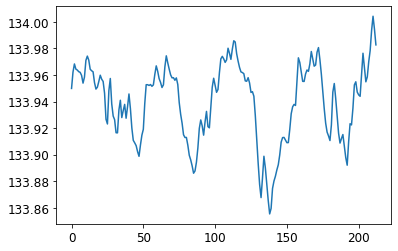

In [75]:
df['B10-1'].plot()

In [76]:
headfile = '{}.hds'.format(ml_name)
fname = os.path.join(tmp_model_ws, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data()

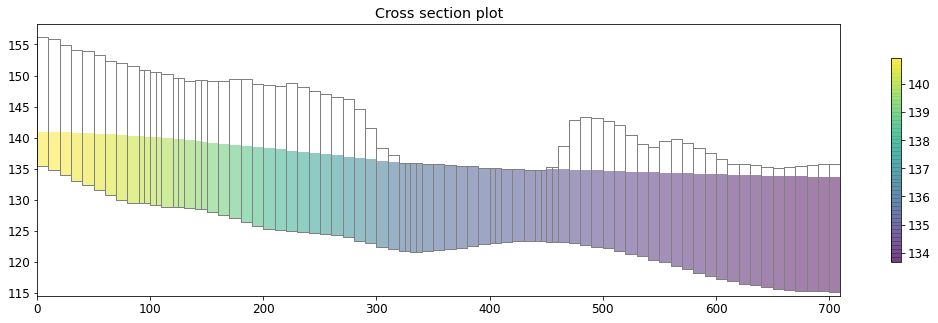

In [77]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Cross section plot")

xsection = np.array([(427000, 6654690), (427540, 6655230)])
xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": xsection})
patch_collection = xsect.plot_array(h, head=h, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

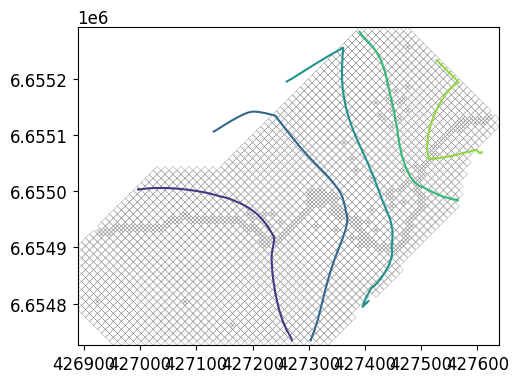

In [78]:
fig = plt.figure(figsize=(8,4), dpi=100)

modelmap = flopy.plot.PlotMapView(model=gwf)
linecollection = modelmap.plot_grid(lw=0.25)
contours = modelmap.contour_array(h)
    
plt.tight_layout()
plt.show()

In [79]:
# get the specific discharge from the cell budget file
cbb_file = os.path.join(tmp_model_ws, f'{ml_name}.cbb')
cbb = flopy.utils.CellBudgetFile(cbb_file)

# get the head from the head file
head_file = os.path.join(tmp_model_ws, f'{ml_name}.hds')
head = flopy.utils.HeadFile(head_file)
hdata = head.get_alldata()

No handles with labels found to put in legend.


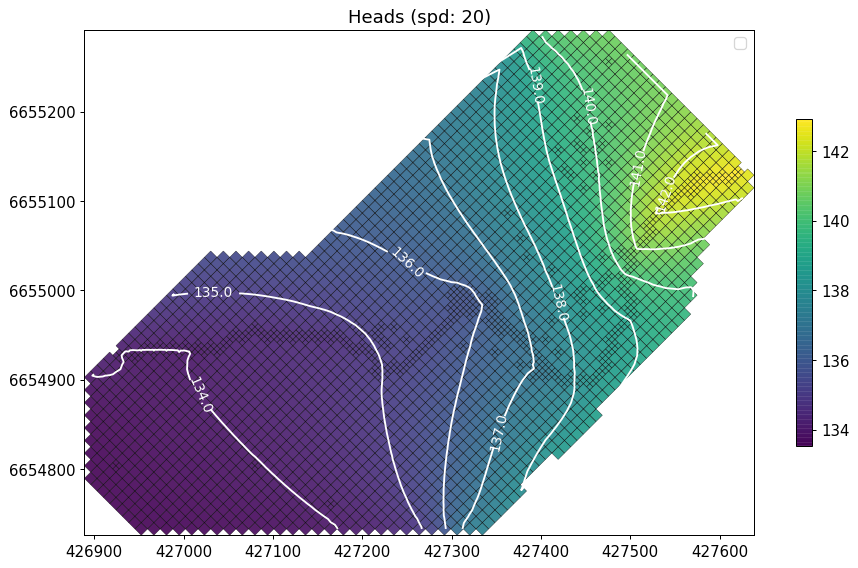

In [80]:
spd = 20

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

levels = np.arange(130, 145, 1.0)
contour_set = mapview.contour_array(hdata[spd], levels=levels, colors='white')
plt.clabel(contour_set, fmt="%.1f", colors='white', fontsize=11)


plt.title(f'Heads (spd: {spd})')
plt.legend()
plt.show()

In [81]:
#Check the budget
mf_list = flopy.utils.Mf6ListBudget(os.path.join(tmp_model_ws, f"{gwf.name}.lst"), timeunit='days') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget()
incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017")

incrementaldf

STO-SS_IN  STO-SY_IN        GHB_IN      RCH_IN       SFR_IN  \
2017-01-10   0.000000   0.000000  10863.588867   50.375801  9449.921875   
2021-02-09   0.003489  60.473499  10953.221680  352.324585  9323.011719   

                TOTAL_IN  STO-SS_OUT  STO-SY_OUT      GHB_OUT  RCH_OUT  \
2017-01-10  20363.886719         0.0         0.0  9110.374023      0.0   
2021-02-09  20689.035156         0.0         0.0  9068.355469      0.0   

                 SFR_OUT     TOTAL_OUT    IN-OUT  PERCENT_DISCREPANCY  
2017-01-10  11253.872070  20364.246094 -0.358500                 -0.0  
2021-02-09  11620.679688  20689.035156 -0.000031                 -0.0

---

End of notebook

---

Delete LR to start over:

In [82]:
#shutil.rmtree(lr_ws)

| parameter | initial | upper bound | lower bound |
| --------- |--------:|-------------| ------------|
| Ks        | 86.4    | 8640.0      | 0.0000864   |
| m         | 1.0     | 2.0         | 0.01        |
| f         | 0.5     | 0.9         | 0.01        |
| γ         | 1.0     | 10.0        | 0.01        |
| f1        | 10.0    | 50.0        | 1.0         |
| f2        | 1.0     | 100.0       | 0.1         |
| p         | 1.0     | 100.0       | 0.01        |
| a_red     | 141.0   | 144.0       | 137.5       |
| a_yellow  | 139.0   | 136.0       | 142.0       |
| a_green   | 133.0   | 128.0       | 136.0       |
| a_blue    | 136.5   | 135.0       | 140.0       |